# Fake news detection using ML 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import tensorflow as tf

## Read datasets

In [2]:
fake = pd.read_csv("Fake.csv")
true = pd.read_csv("True.csv")

In [3]:
fake.shape

(23481, 4)

In [4]:
true.shape

(21417, 4)

## Data cleaning and preparation

In [5]:
# Add flag to track fake and real
fake['target'] = 0
true['target'] = 1

In [6]:
# Concatenate dataframes
data = pd.concat([fake, true]).reset_index(drop = True)
data.shape

(44898, 5)

In [7]:
# Shuffle the data
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [8]:
# Check the data
data.head()

,title,text,subject,date,target
0,Tusk says EU to start transition talks with Br...,BRUSSELS (Reuters) - The chairman of European ...,worldnews,"December 8, 2017",1
1,Phoenix Newspaper Breaks The Internet In Brut...,A Phoenix publication took to its Twitter acco...,News,"August 27, 2017",0
2,BOOM! ACTOR JAMES WOODS Has Hilarious Response...,The hate for the Trump family by the defeated ...,left-news,"Jul 18, 2017",0
3,U.S. approves license for Ukraine to buy small...,WASHINGTON (Reuters) - The U.S. State Departme...,worldnews,"December 21, 2017",1
4,Hillary Clinton Wins Big In SC Democratic Pri...,As the polls close in the all-important South ...,News,"February 27, 2016",0


In [9]:
# Removing the date (we won't use it for the analysis)
data.drop(["date"],axis=1,inplace=True)
data.head()

,title,text,subject,target
0,Tusk says EU to start transition talks with Br...,BRUSSELS (Reuters) - The chairman of European ...,worldnews,1
1,Phoenix Newspaper Breaks The Internet In Brut...,A Phoenix publication took to its Twitter acco...,News,0
2,BOOM! ACTOR JAMES WOODS Has Hilarious Response...,The hate for the Trump family by the defeated ...,left-news,0
3,U.S. approves license for Ukraine to buy small...,WASHINGTON (Reuters) - The U.S. State Departme...,worldnews,1
4,Hillary Clinton Wins Big In SC Democratic Pri...,As the polls close in the all-important South ...,News,0


In [10]:
# Removing the title (we will only use the text)
data.drop(["title"],axis=1,inplace=True)
data.head()

,text,subject,target
0,BRUSSELS (Reuters) - The chairman of European ...,worldnews,1
1,A Phoenix publication took to its Twitter acco...,News,0
2,The hate for the Trump family by the defeated ...,left-news,0
3,WASHINGTON (Reuters) - The U.S. State Departme...,worldnews,1
4,As the polls close in the all-important South ...,News,0


In [11]:
# Convert to lowercase

data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

,text,subject,target
0,brussels (reuters) - the chairman of european ...,worldnews,1
1,a phoenix publication took to its twitter acco...,News,0
2,the hate for the trump family by the defeated ...,left-news,0
3,washington (reuters) - the u.s. state departme...,worldnews,1
4,as the polls close in the all-important south ...,News,0


In [12]:
# Remove punctuation

import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(punctuation_removal)

In [13]:
# Check
data.head()

,text,subject,target
0,brussels reuters the chairman of european uni...,worldnews,1
1,a phoenix publication took to its twitter acco...,News,0
2,the hate for the trump family by the defeated ...,left-news,0
3,washington reuters the us state department ha...,worldnews,1
4,as the polls close in the allimportant south c...,News,0


In [47]:
#pip install nltk

In [14]:
# Removing stopwords
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [15]:
data.head()

,text,subject,target
0,brussels reuters chairman european union leade...,worldnews,1
1,phoenix publication took twitter account expla...,News,0
2,hate trump family defeated liberal press visce...,left-news,0
3,washington reuters us state department approve...,worldnews,1
4,polls close allimportant south carolina democr...,News,0


## Basic data exploration

subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


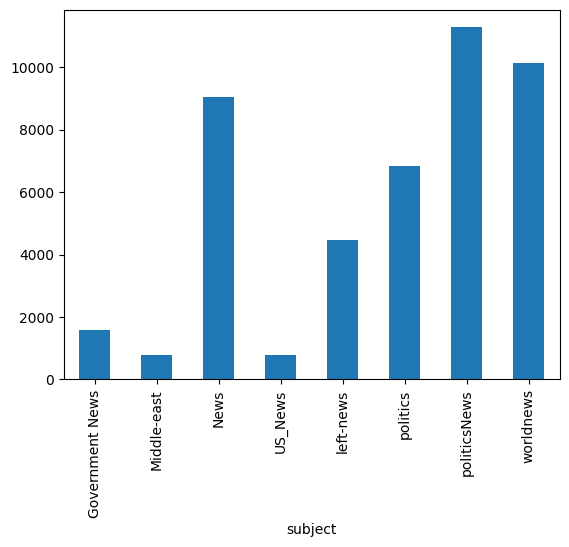

In [16]:
# How many articles per subject?
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

target
0    23481
1    21417
Name: text, dtype: int64


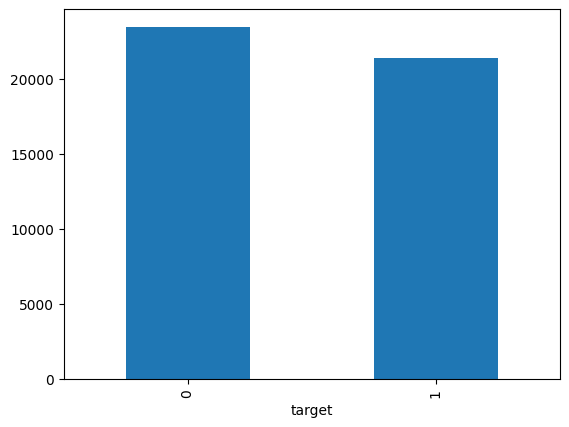

In [17]:
# How many fake and real articles?
print(data.groupby(['target'])['text'].count())
data.groupby(['target'])['text'].count().plot(kind="bar")
plt.show()

In [18]:
# Most frequent words counter (Code adapted from https://www.kaggle.com/rodolfoluna/fake-news-detector)   
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

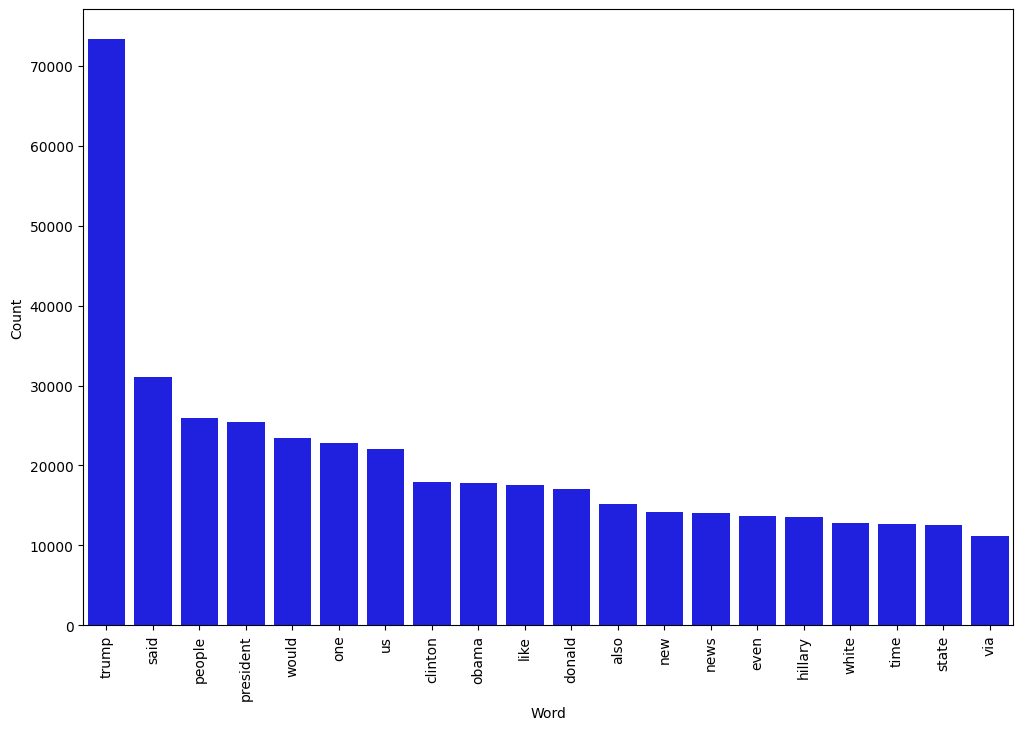

In [19]:
# Most frequent words in fake news
counter(data[data["target"] == 0], "text", 20)

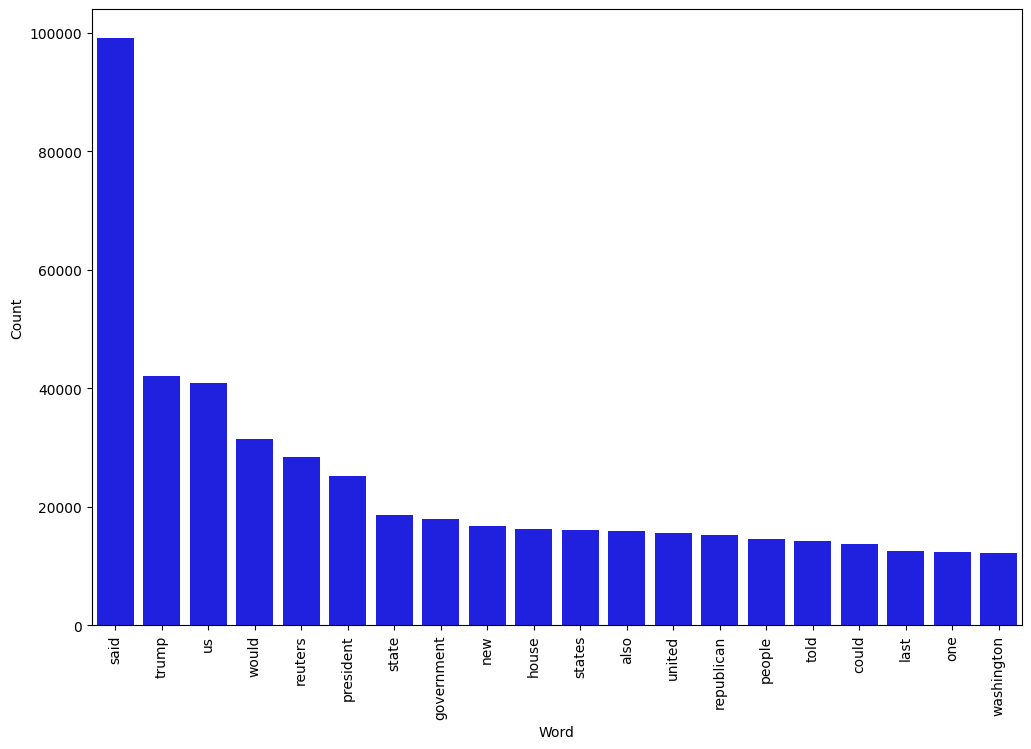

In [20]:
# Most frequent words in real news
counter(data[data["target"] == 1], "text", 20)

## Modeling

In [21]:
# Function to plot the confusion matrix (code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Peparing the data

In [22]:
# Split the data
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.2, random_state=42)

In [23]:
from sklearn.tree import DecisionTreeClassifier
dct = {}
# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20, 
                                           splitter='best', 
                                           random_state=42))])
# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Decision Tree'] = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 99.68%


In [30]:
sample = ['A group of 58 people in the entertainment industry have signed an open letter to President Joe Biden, calling “for a ceasefire in Gaza and Israel”:','hi everyone this is not a fake news'] 
print(model.predict(sample))

[0 0]


Confusion matrix, without normalization


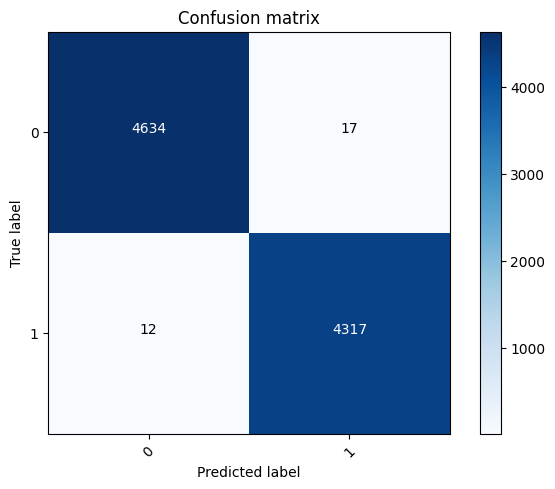

In [31]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=[0, 1])

In [32]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(10000, 128),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1,activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         1280000   
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        98816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               18560     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 128)               4224      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

In [33]:
X_train

36335    washington reuters united states sought monday...
12384    founding fathers wanted separation church stat...
24419    berlin reuters german us employers workers con...
24740    great obama administration came something rega...
27039    trump made pretty insane supporters campaign i...
                               ...                        
11284    really better person roast sarah palin bill ma...
44732    washington reuters former fbi chief james come...
38158    vp candidate mike pence norfolk va holding ral...
860      madrid reuters jailed catalonia leader santi v...
15795    new york lpcifr us regulators said open revisi...
Name: text, Length: 35918, dtype: object

In [34]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [35]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=256)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=256)

In [63]:
#y_train=np.array(y_train)

In [36]:
y_train

36335    1
12384    0
24419    1
24740    0
27039    0
        ..
11284    0
44732    1
38158    0
860      1
15795    1
Name: target, Length: 35918, dtype: int64

In [37]:
#early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=1, batch_size=30,)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1198/1198 [==============================] - 622s 513ms/step - loss: 0.1112 - accuracy: 0.4758


In [82]:
import matplotlib.pyplot as plt
history_dict = history.history

acc = history_dict['accuracy']
loss = history_dict['loss']
print(acc,loss)

[0.0] [1.0]


In [38]:
pred = model.predict(X_test)

281/281 [==============================] - 29s 98ms/step


In [42]:
acc_Neural = accuracy_score(pred, y_test)*100
print('Accuracy on testing set:', acc_Neural)
dct['LSTM'] = acc_Neural

Accuracy on testing set: 48.207126948775056


# **Comparing** **Different Models**

(0.0, 100.0)

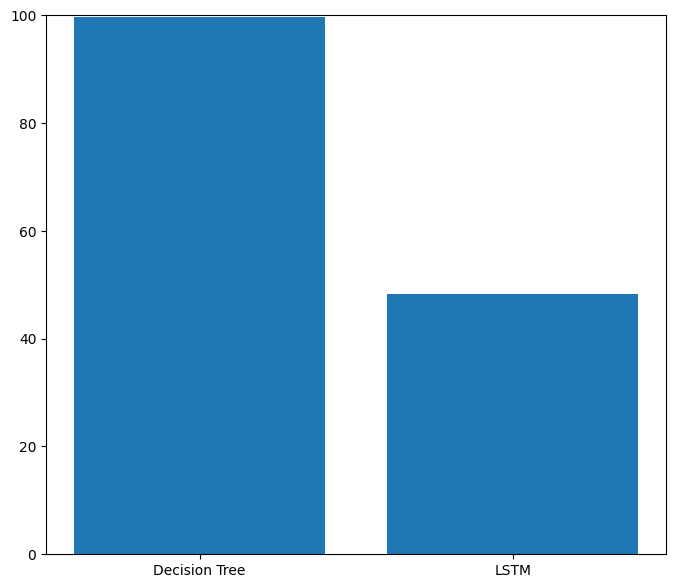

In [44]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,7))
plt.bar(list(dct.keys()),list(dct.values()))
plt.ylim(0,100)
